In [3]:
%load_ext autoreload

In [4]:
autoreload 2

In [5]:
%matplotlib inline

In [6]:
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import sympy as sym

import inputs
import models
import shooting

from __future__ import division

### Welcome to the Estimation notebook!

This notebook defines some workers and firms - usign parameters obtained from Distributions.ipynb - solves for a first run of the model and then uses the estimation code to get the sum of squared residuals between data (taken from PD05_wage.csv) and the implied functions of the model: mu(x), theta(x), w(x)

In [7]:
# define some default workers skill
x, mu1, sigma1 = sym.var('x, mu1, sigma1')
skill_cdf = 0.5 + 0.5 * sym.erf((sym.log(x) - mu1) / sym.sqrt(2 * sigma1**2))
skill_params = {'mu1': 3.8894753094349528, 'sigma1': 0.63718247398434291}
skill_bounds = [0.01, 340.6127]

workers = inputs.Input(var=x,
                       cdf=skill_cdf,
                       params=skill_params,
                       bounds=skill_bounds,
                       )

# define some default firms
y, mu2, sigma2 = sym.var('y, mu2, sigma2')
productivity_cdf = 0.5 + 0.5 * sym.erf((sym.log(y) - mu2) / sym.sqrt(2 * sigma2**2))
productivity_params = {'mu2': 7.13768801209, 'sigma2': 1.92573671813}
productivity_bounds = [1.93, 1151284.0]

firms = inputs.Input(var=y,
                     cdf=productivity_cdf,
                     params=productivity_params,
                     bounds=productivity_bounds,
                     )

# define symbolic expression for CES between x and y
omega_A, sigma_A = sym.var('omega_A, sigma_A')
A = ((omega_A * x**((sigma_A - 1) / sigma_A) + 
     (1 - omega_A) * y**((sigma_A - 1) / sigma_A))**(sigma_A / (sigma_A - 1))) 

# define symbolic expression for Cobb-Douglas between l and r
l, r, omega_B, sigma_B = sym.var('l, r, omega_B, sigma_B')
B = l**omega_B * r**(1 - omega_B)

F = A * B

F_params = {'omega_A':0.75, 'omega_B':0.75, 'sigma_A':0.6, 'sigma_B':1.0}

model = models.Model('positive',
                     workers=workers,
                     firms=firms,
                     production=F,
                     params=F_params)

solver = shooting.ShootingSolver(model=model)

** Now that everything is defined, let's try to solve the model once first! **

This will give us a good idea about inital guesses and number of knots.

In [8]:
solver.solve(20000, tol=1e-6, number_knots=6000, atol=1e-15, rtol=1e-12, integrator='vode', message=False)

Success! All workers and firms are matched


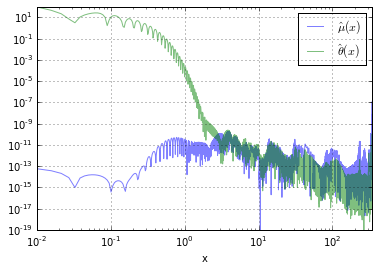

In [9]:
# Plotting the residuals
solver.residuals.plot(loglog=True, alpha=0.5)
plt.show()

** Time to import the estimation_code **

In [76]:
import estimation_code_1 as est

Now we can try if the objective function works:

In [78]:
# Starting, arbitrary parameters
ps = (0.75, 0.75, 0.6)

# Reading data from csv file
xs, ys, thetas, ws = est.import_data('data05.csv', ID=False)
ys = np.log(ys)   # Y proxied by log profit

# Worker skill parameters are taken from Histograms.ipynb - and correspond to log wages mean and variance
skill_p = (3.8894753094349528, 0.63718247398434291)
skill_b = [0.01, 340.6127]

# Firm skill parameters are also taken from Histograms.ipynb - and correspond to log profit mean and variance (firm level)
firm_p = (7.13768801209, 1.92573671813)
firm_b = [1.93, 1151284.0]

# Run!
est.ObjectiveFunction(ps, (xs, ys, thetas, ws), skill_p, skill_b, firm_p, firm_b, 500.0)

Success! All workers and firms are matched


20857637.952813957

Or try the two functions individually:

In [99]:
# SolveModel
functions, new_guess = est.Solve_Model(F, F_params, workers, firms, 'positive', 6000.0, 'vode', 500.0)
mu_hat, theta_hat, w_hat = functions

Success! All workers and firms are matched


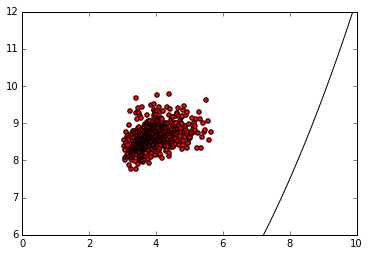

In [102]:
# Plotting the function vs the data (some fit better than others)
mus1 = []
x_range = np.linspace(0, 10, 100)
for i in range(100):
    mus1.append(mu_hat(x_range[i]))
plt.plot(x_range, mus1, c='black')
plt.scatter(xs, ys, c='r')
plt.xlim(0,10)
plt.ylim(6,12)
plt.show()

In [36]:
# Checking the mean square error - actually, the sum of squared errors of mu(x), theta(x), w(x)
est.Calculate_MSE( (xs, ys, thetas, ws), (mu_hat, theta_hat, w_hat) )

27725118424593.789

## Iterate for some parameters

In [95]:
om = 1.0
h_theta = 100
results_i = []
not_working = []
for i in range(42):
    om -= 0.02
    params_i = {'omega_A':0.75, 'omega_B':om, 'sigma_A':0.6, 'sigma_B':1.0}
    try:
        functions, guess = est.Solve_Model(F, params_i, workers, firms, 'positive', 6000, 'lsoda', h_theta)
        mu_hat, theta_hat, w_hat = functions
        results_i.append(est.Calculate_MSE((xs, ys, thetas, ws), (mu_hat, theta_hat, w_hat)))
        h_theta = guess
        print 'Done with', om
    except AssertionError:
        not_working.append(om)
        print 'Skipped error', om
        pass


Skipped error 0.98
Skipped error 0.96
Skipped error 0.94
Success! All workers and firms are matched
Done with 0.92
Success! All workers and firms are matched
Done with 0.9
Success! All workers and firms are matched
Done with 0.88
Success! All workers and firms are matched
Done with 0.86
Success! All workers and firms are matched
Done with 0.84
Success! All workers and firms are matched
Done with 0.82
Success! All workers and firms are matched
Done with 0.8
Success! All workers and firms are matched
Done with 0.78
Success! All workers and firms are matched
Done with 0.76
Success! All workers and firms are matched
Done with 0.74
Success! All workers and firms are matched
Done with 0.72
Success! All workers and firms are matched
Done with 0.7
Success! All workers and firms are matched
Done with 0.68
Success! All workers and firms are matched
Done with 0.66
Success! All workers and firms are matched
Done with 0.64
Success! All workers and firms are matched
Done with 0.62
Success! All worke

In [25]:
results_i

### Appendix

In [ ]:
# Pottentially useful bit of code
rxs = solver.solution.index.values
rmus = solver.solution['$\\mu(x)$'].values
rthetas = solver.solution['$\\theta(x)$'].values
rws = solver.solution['$w(x)$'].values